# Assignment 6: Model Predictive Control

***

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I

**Released:** 11/12/2024

**Due on Gradescope:** 11/24/2024 at 11:59pm

**Submission Instructions:**


*   Make a copy of this colab notebook in your drive. (File -> Save a copy in Drive)
*   Complete your homework by writing code in your copy of the notebook and writing answers to the written questions.
* When you are ready to submit, run all your cells so the outputs show in this notebook.
* Save your colab notebook as a PDF. (File -> Print -> Save as PDF).
* If required, combine the colab PDF with a PDF of any written answers.
* Submit three files on **Gradescope**:
  * PDF of Colab answers and written answers. Please select corresponding pages of your PDF for each question--makes it much easier to grade!!
  * Python notebook of Colab (File -> Download -> Download .ipynb)
  * Python file to check for plagiarism (File -> Download -> Download .py)

These notes were developed by Fionna Kopp, Charlott Vallon, Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

If you are enrolled in ME C231A/EE C220B you may take notes and make copies of course materials for your own use. You may also share those materials with another student who is registered and enrolled in this course, and with DSP.

You may not reproduce, distribute or display lecture notes or recordings or course materials in any other way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

***

In this homework assignment, we are going to use the $\texttt{Polytope}$ package. You can find the documentation here: https://tulip-control.github.io/polytope/

In [1]:
# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install polytope

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123633 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

The following helper functions compute the Minkowski sum, precursor set and $O_{\infty}$ set.

In [2]:
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget

# Helper Functions:

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on
    # vertex enumeration
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X

    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))



def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)



def Oinf(Xset, A, Wset=pt.Polytope()):
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap

def Cinf(Xset, A, Uset, B, Wset=pt.Polytope()):

    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Uset, B, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap

***

# <font color=blue> 1. Formulation of CFTOC Problem with Pyomo</font>

In this problem, you will write a function which formulates and solves a finite time optimal control problem with quadratic cost, linear dynamics, and linear constraints. You will be using this function in the next part of the homework as a part of your MPC controller. Consider the problem defined below:
\begin{equation}
\begin{aligned}
\min_{x_1 \dots x_N,u_0 \dots u_{N-1}} & \quad x_N^{\top}Px_N+\sum_{k=0}^{N-1}x_k^{\top}Qx_k+u_k^{\top}Ru_k \\
\text{s.t.} & \quad x_{k+1} = Ax_k + Bu_k \quad \forall k=0\dots N-1\\
& \quad x_{min} \leq x_k \leq x_{max}  \quad \forall k=0\dots N-1 \\
& \quad u_{min} \leq u_k \leq u_{max}  \quad \forall k=0\dots N-1 \\
& \quad x_0 = x(0) \\
& \quad x_N \in {X}_f
\end{aligned}
\end{equation}

Write a function in the following form which formulates the problem using pyomo and solves the problem using the solver $\texttt{ipopt}$. Test your code on several 1 and 2-state examples.

`def solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af):
    return [feas, xOpt, uOpt, JOpt]`


- $\texttt{feas}$ is a scalar logical indicating the feasibility of the CFTOC problem
- $\texttt{xOpt}$ is a $n_x \times (N+1)$ matrix of the optimal state trajectory, where $n_x$ is the state dimension
- $\texttt{uOpt}$ is a $n_u \times N$ matrix of the optimal input sequence, where $n_u$ is the input dimension
- $\texttt{JOpt}$ is a scalar of the optimal cost from the specified initial condition
- $\texttt{A, B}$ are the state and input matricies of the linear dynamics
- $\texttt{P}$ is the terminal cost matrix
- $\texttt{Q, R}$ are the stage cost matricies
- $\texttt{N}$ is the MPC horizon
- $\texttt{x0}$ is the initial condition
- $\texttt{xL, xU, uL, uU}$ are the box state and input constraints
- $\texttt{bf, Af}$ are used to represent the terminal set. If the terminal set $X_f$ is a single point, $X_f = \{ \bar{x}_N \}$, the input argument $\texttt{bf}$ is used to specify this single point $\bar{x}_N$, and the input argument $\texttt{Af = []}$ is used to designate this special case of a single-point terminal set. If the terminal set is described by a set of linear inequalities, it can be expressed using the inequality $A_f x_N \leq b_f$.


### <font color=red> Deliverable 1 (10 pts): write your answer in the code cell below. Show the results of the unit test in your write-up

In [3]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import polytope as pt

# Write your code here
def solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af):

  model = pyo.ConcreteModel()
#variables

  model.kidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
  model.xidx = pyo.Set(initialize=range(0, A.shape[0]))
  model.uidx = pyo.Set(initialize=range(0, B.shape[1]))

#variables
  model.x = pyo.Var(model.xidx, model.kidx)
  model.u = pyo.Var(model.uidx, model.kidx)


#objective function
  model.J = pyo.Objective(expr=sum(
    sum(model.x[i, k] * Q[i, j] * model.x[j, k] for i in model.xidx for j in model.xidx) +  # x'Qx
    sum(model.u[i, k] * R[i, j] * model.u[j, k] for i in model.uidx for j in model.uidx)  # u'Ru
    for k in range(N)) +
    sum(model.x[i, N] * P[i, j] * model.x[j, N] for i in model.xidx for j in model.xidx))  # x'Px (terminal cost)

#constraints

  model.constraint1 = pyo.Constraint(model.xidx, rule = lambda model, i:model.x[i,0] == x0[i])

  model.constraint2 = pyo.Constraint(model.xidx, model.kidx, rule = lambda model, i, k: model.x[i,k+1] == sum(A[i,j]* model.x[j,k] for j in model.xidx) + sum(B[i,j]*model.u[j,k] for j in model.uidx)
                                     if k < N else pyo.Constraint.Skip)
  model.constraint3 = pyo.Constraint(model.xidx, model.kidx, rule = lambda model, i, k: model.x[i,k] >= xL
                                     if k < N else pyo.Constraint.Skip)
  model.constraint4 = pyo.Constraint(model.xidx, model.kidx, rule = lambda model, i, k: model.x[i,k] <= xU
                                     if k < N else pyo.Constraint.Skip)
  model.constraint5 = pyo.Constraint(model.uidx, model.kidx, rule = lambda model, i, k: model.u[i,k] >= uL
                                     if k < N-1 else pyo.Constraint.Skip)
  model.constraint6 = pyo.Constraint(model.uidx, model.kidx, rule = lambda model, i, k: model.u[i,k] <= uU
                                     if k < N-1 else pyo.Constraint.Skip)
  #model.constraint7 = pyo.Constraint(model.xidx, rule=lambda model, i: model.x[i,N] == bf[i]) # activate for 2a

  model.constraint8 = pyo.Constraint(model.xidx, rule=lambda model, i: sum(Af[i,j]*model.x[j,N] for j in model.xidx) <= bf[i]) #activate for 2b and 2c

  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model, tee = False)
  #feas = (results.solver.status==1)
  feas = results.solver.termination_condition == pyo.TerminationCondition.optimal

  #Extract
  if feas:
    xOpt = np.array([[model.x[i,k].value for k in model.kidx] for i in model.xidx])
    uOpt = np.array([[model.u[i,k].value for k in model.kidx] for i in model.uidx])
    JOpt = pyo.value(model.J)

  return [feas, xOpt, uOpt, JOpt]


JOpt= 9.178413778555779
xOpt= [[ 2.       1.4      0.72912  0.31353  0.11136  0.02947  0.00256 -0.00343
  -0.00317 -0.00185 -0.00087 -0.00034 -0.00011 -0.00002 -0.00001 -0.00003]
 [-1.      -0.95088 -0.5614  -0.26488 -0.10416 -0.03281 -0.00651  0.00095
   0.00195  0.00135  0.0007   0.0003   0.0001   0.00002 -0.00002 -0.00003]]
uOpt= [[0.049115535630404605 0.38948002319512887 0.29652009603810425
  0.16072767797505388 0.07135036937004735 0.026300729552127183
  0.007459588813159569 0.000995927542359543 -0.0005961887309749145
  -0.0006519018538526112 -0.00040204018615749073 -0.0001966898649641859
  -8.349725767138918e-05 -3.48738198097767e-05 -1.758819200596126e-05
  None]]
Feas= True


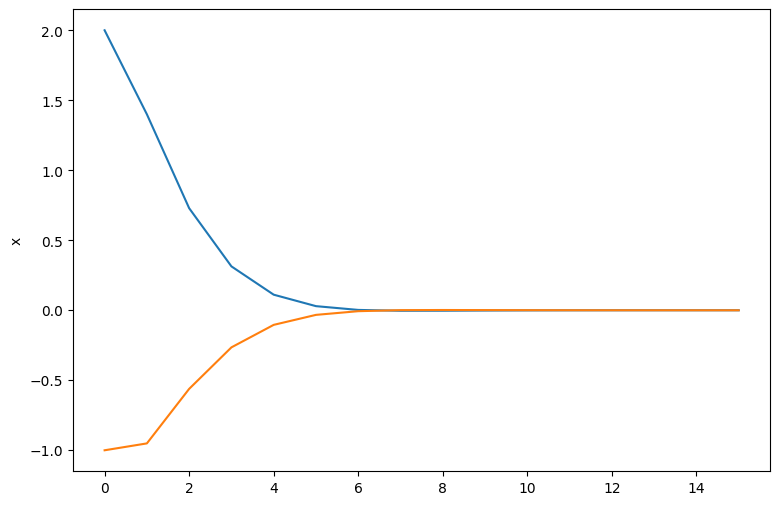

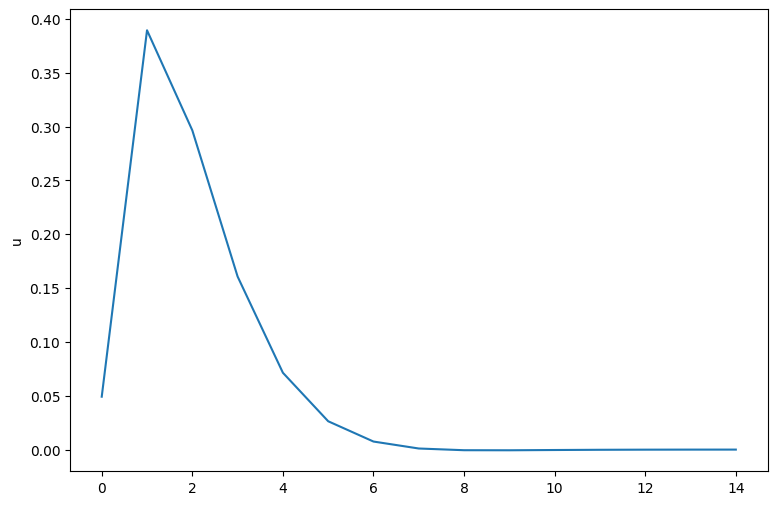

In [4]:
#Unit test
A = np.array([[1.2, 1],
               [0, 1]])
B = np.array([[0],
              [1]])
Q = np.eye(2)
R = np.array([1]).reshape(1,1)
P = Q
N = 15
xL = -15
xU = 15
uL = -1
uU = 1
x0 = np.array([2, -1])

Af = np.array([[1, 0],
               [0, 1],
               [-1, 0],
               [0, -1]])

bf = np.zeros((4, ))

[feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af)

print('JOpt=', JOpt)
print('xOpt=', xOpt)
print('uOpt=', uOpt)
print('Feas=', feas)
fig = plt.figure(figsize=(9, 6))
plt.plot(xOpt.T)
plt.ylabel('x')
fig = plt.figure(figsize=(9, 6))
plt.plot(uOpt.T)
plt.ylabel('u')
plt.show()


***

# <font color=blue> 2. Persistently Feasible and Asymptotically Stable Linear MPC design </font>


Consider the following system

\begin{equation}
x(k+1)=\begin{bmatrix} 1.2 &  1\\ 0 & 1 \end{bmatrix}x(k)+
     \begin{bmatrix} 0\\ 1 \end{bmatrix}u(k) \quad \quad (1)   
\end{equation}

The state and input constraints are
\begin{equation}\begin{aligned}
U: &-1\leq u(k)\leq 1 \quad \quad \quad \quad \quad \quad \quad \quad \quad (2a)\\
X: &\begin{bmatrix} -15\\ -15 \end{bmatrix} \leq x(k) \leq \begin{bmatrix} 15\\ 15 \end{bmatrix} \quad \quad \quad \quad \quad \quad (2b)
\end{aligned}
\end{equation}

In this problem, we will design several MPC controllers of the form:

\begin{equation*}
   \begin{array}{lll}
       J_0^*(x(t))=  &\displaystyle{\min_{{U_0}}}& \displaystyle{ \color{red}{x_N'Px_N} + \sum_{k=0}^{{N}-1}
  x_k'Qx_k+u_k'Ru_k} \\
       &\text{subject to}   \\
       &&x_{k+1}=Ax_{k}+Bu_{k},\ k=0,\ldots,N-1\\
                       &&x_{k}\in X,~u_{k}\in U,~k=0,\ldots,N-1\\
                       && \color{red}{{x_{N}\in {X_f} }} \\
                       && x_{0}=x(t)
    \end{array}
\end{equation*}
We will consider constant dynamics ($A$, $B$), constraint sets $X$ and $U$, $Q=I_2$, $R=1$, and $N=3$ and only examine how the choice of $P$ and $X_f$ affect the set of feasible initial states $X_0$.



# <font color=blue> Part a) Approach 1 <font>

Choose $X_f=\{0\}$ (note that $x_N'Px_N=0$ for any $P$ since $x_N=0$). Write code to formulate and solve the MPC problem over a simulation horizon $M$ from initial conditions $x_0$. Print out $\texttt{feas}$, $\texttt{xOpt}$, and $\texttt{uOpt}$ arrays.

$\texttt{feas}$ is a $1 \times M$ vector of logicals that indicate the feasibility of the problem at each simulation step (e.g. if the problem is feasible for 3 steps, then $\texttt{feas}=[\texttt{true true true false} ... \texttt{false}])$ . If the problem becomes infeasible at any time, you should return empty arrays for $\texttt{xOpt}$, $\texttt{uOpt}$, and $\texttt{predErr}$.
$\texttt{xOpt}$ is an array of the optimal closed-loop trajectory of size $2 \times (M+1)$.
$\texttt{uOpt}$ is an array of the optimal input sequence of size $1 \times M$.

You should call the function $\texttt{solve_cftoc}$ that you wrote in Problem 1 in the simulation loop.

### <font color=red> Deliverable 2a (15 pts): write your answer in the two code cells below.</font>

In [5]:
import numpy as np
import polytope as pt


# Write your code here:
A = np.array([[1.2, 1],
               [0, 1]])
B = np.array([[0],
              [1]])

nx = A.shape[1]
nu = B.shape[1]

x0 = np.array([2, -1])


xL = -15 #np.array([-15, -15])
xU =  15 #np.array([15, 15])
uL = -1 #np.array([-1, -1])
uU = 1 #np.array([1, 1])

X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[xU],
                          [xU],
                          [xU],
                          [xU]]))

U = pt.Polytope(np.array([[ 1],
                          [-1]]),
                np.array([[ uU],
                          [ uU]]))


Q = np.eye(nx)
R = np.eye(nu)
P = np.zeros((nx, nx))

M = 25
N = 3



X0= Single polytope 
  [[-0.       1.     ] |    [[3.001  ]
   [-0.76822 -0.64018] |     [1.51297]
   [ 0.76822  0.64018] |     [1.51297]
   [ 0.      -1.     ] x <=  [3.001  ]
   [ 0.42885  0.90337] |     [0.79442]
   [ 0.54766  0.8367 ] |     [0.69789]
   [-0.54766 -0.8367 ] |     [0.69789]
   [-0.42885 -0.90337]]|     [0.79442]]



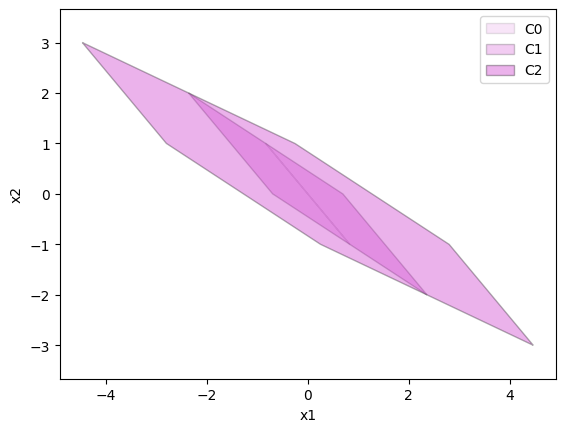

In [6]:
eps = 0.001
S = pt.box2poly([[-eps, eps], [-eps, eps]])

Xf = S #terminal constrain is very very close to zero
Af = Xf.A
bf = Xf.b


C = {}
PreS = precursor(S,A,U,B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0a = C[N-1]

prep = precursor(X, A)

print('X0=', X0a)

# Plotting
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

C[0].plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # K[0] is one step controllable set
C[1].plot(ax, color='m', alpha=0.2, linestyle='solid', linewidth=1)                      # K[1] is two step controllable set
C[2].plot(ax, color='m', alpha=0.3, linestyle='solid', linewidth=1)                      # K[2]

ax.legend(['C0', 'C1', 'C2'])

ax.autoscale_view()
ax.axis('equal')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

feasibility: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
xOpt: [[ 2.       1.4      0.65295  0.24431  0.05535 -0.02051 -0.04242 -0.04178
  -0.03389 -0.02505 -0.01751 -0.01177 -0.00766 -0.00483 -0.00294 -0.0017
  -0.00094 -0.00049 -0.00024 -0.00011 -0.00004 -0.00001 -0.       0.
   0.      -0.     ]
 [-1.      -1.02705 -0.53923 -0.23783 -0.08693 -0.0178   0.00912  0.01625
   0.01561  0.01255  0.00925  0.00646  0.00436  0.00286  0.00182  0.0011
   0.00064  0.00035  0.00018  0.00009  0.00004  0.00001  0.      -0.
  -0.      -0.     ]]
uOpt: [[-0.02705  0.48782  0.3014   0.1509   0.06912  0.02692  0.00713 -0.00064
  -0.00307 -0.0033  -0.00278 -0.0021  -0.0015  -0.00104 -0.00072 -0.00047
  -0.00029 -0.00017 -0.00009 -0.00005 -0.00002 -0.00001 -0.      -0.
   0.     ]]
xPred: [[[ 2.       1.4      0.65295  0.24431  0.05535 -0.02051 -0.04242
   -0.04178 -0.03389 -0.02505 -0.01751 -0.0

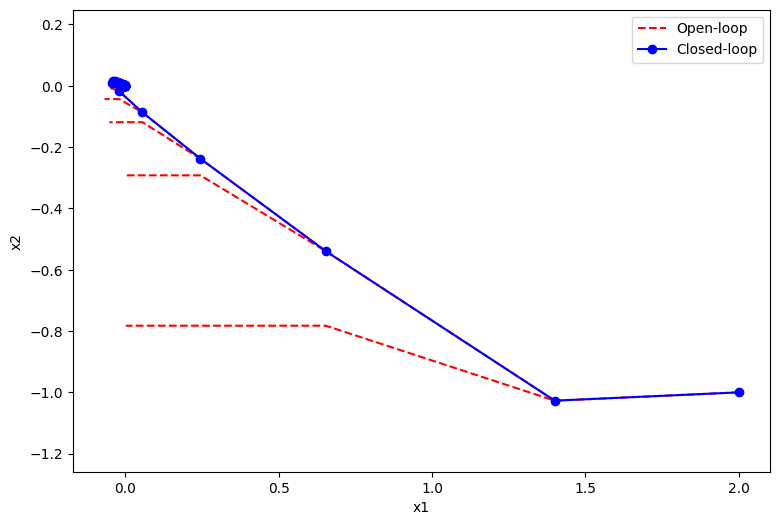

In [7]:
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:,0] = x0.reshape(nx,)

xPred = np.zeros((nx, N+1, M)) #
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M,), dtype=bool)

fig = plt.figure(figsize=(9, 6))

for i in range(M):
    [feas[i],x,u,J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:,i], xL, xU, uL, uU, bf, Af)
    #feas[i] = J[0]
    if not feas[i]:
        xOpt = []
        uOpt = []
        predErr = []
        break

    xPred[:,:,i] = x

    xOpt[:,i+1] = x[:,1] #A @ xOpt[:,i] + B @ J[2][:,i]
    uOpt[:,i] = u[:,0].reshape(nu,)

       # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
#plt.legend([line1[0]], ['Open-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

print("feasibility:", feas)
print("xOpt:", xOpt)
print("uOpt:", uOpt)
print("xPred:", xPred)

In the case of closed loop we see a continious trajectory, whereas in the open loop we see a set of erratic trajectories overlapping, sometimes aligning and sometimes not aligned with closed loop

Answer the following questions:

1.  Let $x(0) = [2,-1]^T$. On the same figure, plot the closed-loop state trajectory as well as the open-loop trajectories (dashed lines) predicted by the MPC with a simulation horizon of $M=25$.

2. For the same $x(0) = [2,-1]^T$, analyze the mismatch between predicted vs closed-loop trajectories.

3. Plot the set of feasible initial states $X_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

4. Is $X_0$ an invariant set for the dynamic system (1) subject to the constraints (2) under the MPC law you designed? Justify your answer. (Hint: look at the Reachability slides for the definition of an invariant set.)

5. Is the MPC you just designed persistently feasible for all initial states in $X_0$?  

6. Is the origin asymptotically stable for the closed loop system?

7.  What is its region of  attraction?

Answers
1. See plot above

2. In the case of closed loop we see a continious trajectory, whereas in the open loop we see a set of erratic trajectories overlapping, sometimes aligning and sometimes not aligned with closed loop. Open loop has multiple trayectories that are not able to make it to zero zero, final state.

Now, the predictions on open loop are made based on the limitation of the options at each step, whereas with closed loop we are actually considering inputs that put us "on track" early on.

3. Here is the plot of X0, comming up next


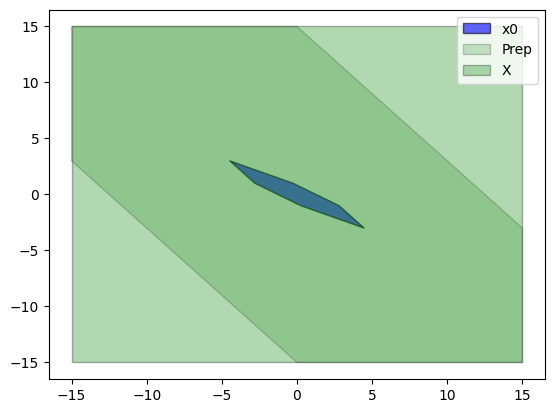

In [9]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_aspect('equal')

#S.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)
X0a.plot(ax, color='b', alpha=.6, linestyle='solid', linewidth=1)
prep.intersect(X).plot(ax, color='g', alpha=.2, linestyle='solid', linewidth=1)
X.plot(ax, color='g', alpha=.3, linestyle='solid', linewidth=1)
ax.legend(['x0','Prep','X'])
ax.autoscale_view()
plt.show()

4. yes, it is, becasue x(0) belongs to Oinf
5. yes, it is persistently feasible for all initial states in x0

6. Since we chose the terminal constraint XN E Xf = 0 then equilibrium point 0, 0 is asymptotically stable according to Lyapunov

7. The region of atraction is x0:
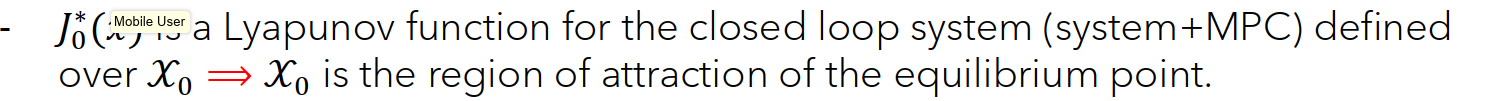

***

# <font color=blue> Part b) Approach 2 </font>

To design the different terminal set, now use a stabilizing controller $u = Kx$ where $K$ is:
\begin{align*}
K &= -\begin{bmatrix}  1.595  &  2.35 \end{bmatrix}
\end{align*}
which  produces a stable closed loop system with poles at 0.1 and -0.25. Let ${{X}_f}$ be the maximal invariant set $O_\infty$ for a closed loop system $x(k+1) = (A+BK)x(k)$ subject to
constraints (2).
Find a new terminal cost that is a Lyapunov Function for $x \in {{X}_f} = O_\infty$ (note: you should be able to design a quadratic terminal cost with weight $P$ by simply using $\texttt{scipy.linalg.solve_discrete_lyapunov}$). Write the code to formulate and solve the MPC problem with the terminal set and the terminal cost. Your MPC code will be largely similar to the one from Approach 1, with the exception of the terminal constraint and terminal costs. Print out $\texttt{feas}$, $\texttt{xOpt}$, and $\texttt{uOpt}$ arrays.

$\texttt{feas}$ is a $1 \times M$ vector of logicals that indicate the feasibility of the problem at each simulation step (e.g. if the problem is feasible for 3 steps, then $\texttt{feas}=[\texttt{true true true false} ... \texttt{false}]$) . If the problem becomes infeasible at any time, you should return empty arrays for $\texttt{xOpt}$, $\texttt{uOpt}$, and $\texttt{predErr}$.
$\texttt{xOpt}$ is an array of the optimal closed-loop trajectory of size $2 \times (M+1)$.
$\texttt{uOpt}$ is an array of the optimal input sequence of size $1 \times M$.

You should call the function $\texttt{solve_cftoc}$, that you wrote in Problem 1, in the simulation time loop.


### <font color=red> Deliverable 2b (15 pts): write your answer in the three code cells below.</font>

In [10]:
import scipy.linalg
import numpy as np
import polytope as pt

# Fill in the blanks:

K = -np.array([1.595, 2.35]).reshape(1,2)
A_cl = A + B@K
P_2 = scipy.linalg.solve_discrete_lyapunov(A_cl.T, Q+K.T@R@K)
#K = np.array([1.595, 2.35])*-1
#A_cl = A + B@(K.reshape(1,-1))  # closed-loop A matrix
#P_2 = scipy.linalg.solve_discrete_lyapunov(A_cl, P)

#S = X.intersect(pt.Polytope(U.A@ K.reshape(1,-1), U.b)) # ?????
S = X.intersect(pt.Polytope(U.A@K, U.b))
O_infb = Oinf(S , A_cl)

#S = O_inf
Af = O_infb.A
bf = O_infb.b
K

array([[-1.595, -2.35 ]])

In [11]:
C = {}
PreS = precursor(O_infb, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0b = C[N-1]

Cinfset = Cinf(X, A, U, B)

feasibility: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
xOpt: [[ 2.       1.4      0.72324  0.30804  0.1085   0.02868  0.00274 -0.00301
  -0.00281 -0.00163 -0.00076 -0.00029 -0.00009 -0.00002  0.       0.00001
   0.       0.       0.       0.       0.       0.      -0.      -0.
  -0.      -0.     ]
 [-1.      -0.95676 -0.55985 -0.26115 -0.10151 -0.03168 -0.0063   0.0008
   0.00174  0.0012   0.00062  0.00026  0.00009  0.00002  0.      -0.
  -0.      -0.      -0.      -0.      -0.      -0.       0.       0.
   0.       0.     ]]
uOpt: [[ 0.04324  0.39691  0.2987   0.15964  0.06984  0.02537  0.0071   0.00095
  -0.00054 -0.00059 -0.00036 -0.00017 -0.00007 -0.00002 -0.       0.
   0.       0.       0.       0.       0.       0.       0.      -0.
  -0.     ]]
xPred: [[[ 2.       1.4      0.72324  0.30804  0.1085   0.02868  0.00274
   -0.00301 -0.00281 -0.00163 -0.00076 -0.00029 -0.0

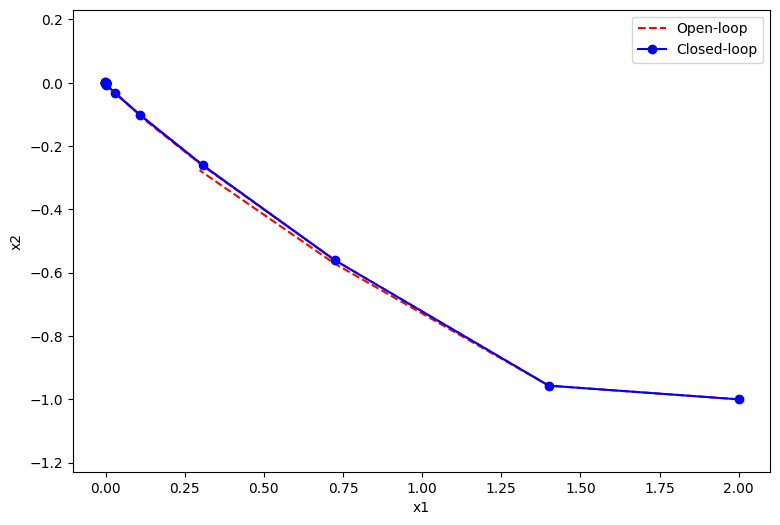

In [12]:
x0 = np.array([2,-1])
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:,0] = x0.reshape(nx,)

xPred = np.zeros((nx, N+1, M)) #
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M,), dtype=bool)

fig = plt.figure(figsize=(9, 6))

for i in range(M):
    [feas[i],x,u,J] = solve_cftoc(A, B, P_2, Q, R, N, xOpt[:,i], xL, xU, uL, uU, bf, Af)
    #feas[i] = J[0]
    if not feas[i]:
        xOpt = []
        uOpt = []
        predErr = []
        break

    xPred[:,:,i] = x

    xOpt[:,i+1] = x[:,1] #A @ xOpt[:,i] + B @ J[2][:,i]
    uOpt[:,i] = u[:,0].reshape(nu,)

       # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
#plt.legend([line1[0]], ['Open-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

print("feasibility:", feas)
print("xOpt:", xOpt)
print("uOpt:", uOpt)
print("xPred:", xPred)

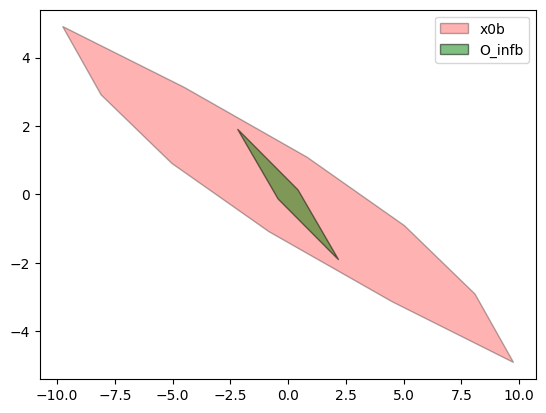

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_aspect('equal')

X0b.plot(ax, color='r', alpha=0.3, linestyle='solid', linewidth=1, edgecolor=None)
#PreS.plot(ax, color='b', alpha=0.2, linestyle='solid', linewidth=1)
O_infb.plot(ax, color='g', alpha=0.5, linestyle='solid', linewidth=1)
#Cinfset.plot(ax, color='r', alpha=0.7, linestyle='solid', linewidth=1)
ax.legend(['x0b','O_infb', 'C_inf'])
ax.autoscale_view()
plt.show()

Answer the following questions:
1.  Let $x(0) = [2,-1]^T$. On the same figure, plot the closed-loop state trajectory as well as the open-loop trajectories (dashed lines) predicted by the MPC with a simulation horizon of $M=25$.


2. For the same $x(0) = [2,-1]^T$, analyze the mismatch between predicted vs closed-loop trajectories.

3. Plot the set of feasible initial states $X_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

4. Is $X_0$ an invariant set for the dynamic system (1) subject to the constraints (2) under the MPC law you designed? Justify your answer.

5. Is the MPC you just designed persistently feasible for all initial states in $X_0$?

6. Is the origin asymptotically stable for the closed-loop system?

7.  What is its region of attraction?

1- Done see above

2- Open loop trayectories deviate from final goal early in the steps N=2 to N=3, and close loop corrects such that we have almost a straight line.

3- See above

4 -yes, because given a feedback controller u=g(x), the invariant set provide the set of initial states whose trajectory will not violate system constraints

5- Yes, if we shose xf to be an invariant set and terminal cost P_2 Lyapunoc the set of feasible initial states Xo is also the states which are, persistently feasible.

6- yes

7- x0

***

# <font color=blue> Part c) Approach 3 </font>
Now set ${X}_f$ to be the maximal invariant set $O_\infty$ for the closed loop system $x(k+1) = (A+BF_\infty)x(k)$ subject to
the given constraints. Here $F_\infty$ is the infinite time LQR controller for the system $x(k+1) = Ax(k)+Bu(k)$ with weights $Q$ and $R$ defined previously, such that $u(k)=F_{\infty}x(k)$. Choose the terminal cost $P$ to be the infinite time cost associated with the controller $F_\infty$. (Hint: Use $\texttt{scipy.linalg.solve_discrete_are}$). Write your code to solve the MPC problem with the terminal set and the terminal cost.

### <font color=red> Delivarable 2c (15 pts): write your answer in the two code cells below.</font>

In [14]:
# Fill in the blanks and write your code

import scipy.linalg

def dlqr(A, B, Q, R):

    # Write your code here:

    P_inf = scipy.linalg.solve_discrete_are(A, B, Q, R)

    F_inf = scipy.linalg.inv(R + B.T @ P_inf @ B) @ (B.T @ P_inf @ A)

    eigVals, eigVecs = scipy.linalg.eig(A - B @ F_inf) ## check the sign watch out

    return F_inf, P_inf, eigVals

F_inf, P_inf, eigvals = dlqr(A, B, Q, R)
A_cl = A - B @ F_inf

S = X.intersect(pt.Polytope(U.A @ F_inf, U.b))

O_infc = Oinf(S, A_cl)

Af = O_infc.A
bf = O_infc.b

F_inf # do not forget the sign

array([[0.68314, 1.41539]])

In [15]:
C = {}
PreS = precursor(O_infc, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0c = C[N-1]

feasibility: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
xOpt: [[ 2.       1.4      0.72912  0.31353  0.11136  0.02947  0.00256 -0.00343
  -0.00317 -0.00185 -0.00087 -0.00034 -0.00011 -0.00002  0.       0.00001
   0.       0.       0.       0.       0.       0.      -0.      -0.
  -0.      -0.     ]
 [-1.      -0.95088 -0.5614  -0.26488 -0.10416 -0.03281 -0.00651  0.00095
   0.00195  0.00135  0.0007   0.0003   0.00011  0.00003  0.      -0.
  -0.      -0.      -0.      -0.      -0.      -0.       0.       0.
   0.       0.     ]]
uOpt: [[ 0.04912  0.38948  0.29652  0.16073  0.07135  0.0263   0.00746  0.001
  -0.0006  -0.00065 -0.0004  -0.00019 -0.00008 -0.00003 -0.00001  0.
   0.       0.       0.       0.       0.       0.       0.      -0.
  -0.     ]]
xPred: [[[ 2.       1.4      0.72912  0.31353  0.11136  0.02947  0.00256
   -0.00343 -0.00317 -0.00185 -0.00087 -0.00034 -0.00

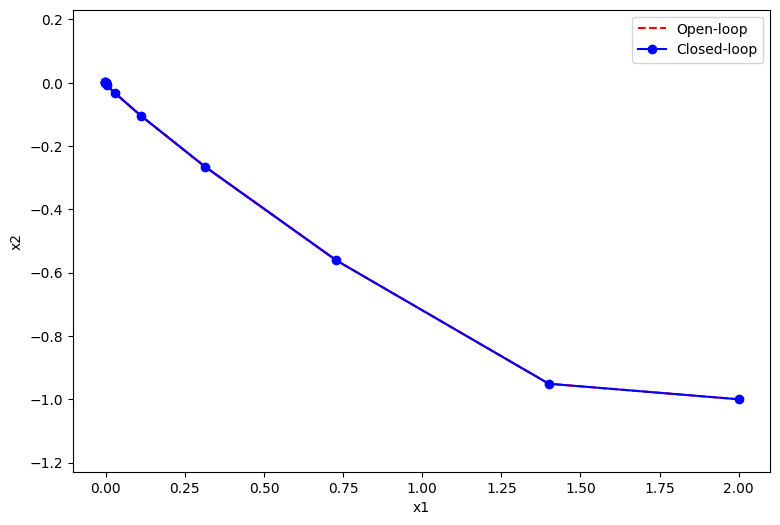

In [16]:
x0 = np.array([2,-1])
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:,0] = x0.reshape(nx,)

xPred = np.zeros((nx, N+1, M)) #
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M,), dtype=bool)

fig = plt.figure(figsize=(9, 6))

for i in range(M):
    [feas[i],x,u,J] = solve_cftoc(A, B, P_inf, Q, R, N, xOpt[:,i], xL, xU, uL, uU, bf, Af)
    #feas[i] = J[0]
    if not feas[i]:
        xOpt = []
        uOpt = []
        predErr = []
        break

    xPred[:,:,i] = x

    xOpt[:,i+1] = x[:,1] #A @ xOpt[:,i] + B @ J[2][:,i]
    uOpt[:,i] = u[:,0].reshape(nu,)

       # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
#plt.legend([line1[0]], ['Open-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

print("feasibility:", feas)
print("xOpt:", xOpt)
print("uOpt:", uOpt)
print("xPred:", xPred)

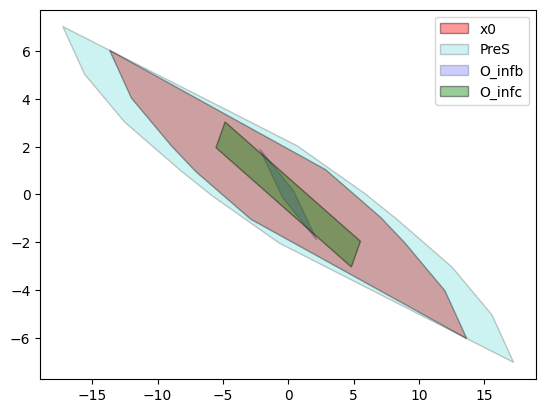

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_aspect('equal')

#X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)
X0c.plot(ax, color='r', alpha=0.4, linestyle='solid', linewidth=1)
PreS.plot(ax, color='c', alpha=0.2, linestyle='solid', linewidth=1)
O_infb.plot(ax, color='b', alpha=0.2, linestyle='solid', linewidth=1)
O_infc.plot(ax, color='g', alpha=0.4, linestyle='solid', linewidth=1)
ax.legend(['x0','PreS','O_infb','O_infc'])
ax.autoscale_view()
plt.show()

Answer the following questions:
1. Plot $O_\infty$ in this approach  with the one in Approach 2 and discuss the differences.

2. Let $x(0) = [2,-1]^T$ and plot the closed-loop state trajectory as well as the open-loop trajectories predicted by the MPC with this new terminal cost and terminal constraint for 25 simulation steps ($N$ is still equal to 3). How does this compare to the other solutions?

3. Plot the set of  feasible initial states $X_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

4. Is $X_0$ an invariant set for the dynamic system (1) subject to the constraints (2) under the MPC law you designed? Justify your answer.


5. Is the MPC you just designed persistently feasible for all initial states in $X_0$?


6. Is the origin asymptotically stable for the closed loop system?


7. What is its region of  attraction?

1 - see above, O_inb is smaller than O_infc

2- in this case the open loop aligns closer to the closed loop, and the open loop is better than the other solutions open loop

3- Plotted, see above

4- yes, because given a feedback controller u=g(x), the invariant set provide the set of initial states whose trajectory will not violate system constraints

5- yes

6- yes

7- yes

***

# <font color=blue> Part d) Comparison </font>
Plot and compare $X_0$ for the three MPC designs (Approach 1, 2, and 3) for $N=3$. What do you notice?

### <font color=red> Delivarable 2d (5 pts): write your answer in the the code cells below.</font>

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_aspect('equal')

#X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)
X0a.plot(ax, color='b', alpha=0.1, linestyle='solid', linewidth=1)
X0b.plot(ax, color='g', alpha=0.2, linestyle='solid', linewidth=1)
X0c.plot(ax, color='r', alpha=0.3, linestyle='solid', linewidth=1)
#S.plot(ax, color='r', alpha=0.7, linestyle='solid', linewidth=1)
ax.legend(['x01','x02','x03'])
ax.autoscale_view()
plt.show()

The region of attraction is reduced from 2 to 3 and, region of attaction 2 is even smaller than 1

# <font color=blue> Question 3. HW6 Summary/Wrapper </font>

Rate your confidence in your homework solutions and understanding of material.

A) I am very confident and feel great about this content.

B) I am somewhat confident.

C) I am not feeling confident.

Any additional comments? (Comments are optional, but please rate either A/B/C. All choices will receive the full 5 points.)

A - I liked this homework very much. Challenging but at the same time instructive. Thank you much for time and dedication put into assembling it. (I collaborated in this homework with Carla Becker, yet code is my own + what we got from the labs and class notes)

### <font color=red> Deliverable 3 (5 pts): Write your answer in your PDF submission or in a text cell here </font>

B - I liked this homework very much. Challenging but at the same time instructive. Thank you much for time and dedication put into assembling it. (I collaborated in this homework with Carla Becker, yet code is my own + what we got from the labs and class notes)

In [ ]:
#
#
#
#





#
#
#
#
##
#
#
##
#
#
##
#
#
##
#
#
##
#
#
##
#
#
##
#
#
##
#
#
#












